In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting={'γ_2p': np.array([0, .0197*2*2, .3853*2]),
                                                        'πd_o': np.array([1./3, 1./3, 1./3])}):
    η = .032
    δ = .01

    θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
    πc_o = np.ones_like(θ)/len(θ)
    σ_y = 1.2*np.mean(θ)

    y_bar = 2.
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    γ_2p = damage_setting['γ_2p']
    πd_o = damage_setting['πd_o']

    y_step = .02
    y_grid_long = np.arange(0., 4., y_step)
    y_grid_short = np.arange(0., 2+y_step, y_step)
    n_bar = find_nearest_value(y_grid_long, y_bar) + 1

    # Prepare ϕ_i
    model_res_list = []
    for γ_2p_i in γ_2p:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=5.,
                           tol=1e-8, max_iter=5_000, print_all=False)
        model_res_list.append(model_res)

    ϕ_list = [res['v0'] for res in model_res_list]

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = ϕ_i[:n_bar]
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    ς = .25
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                                 v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                 ϵ=5., tol=1e-8, max_iter=5_000, print_all=False)

    return model_res_list, model_res

In [3]:
model_res_list, model_res = solve_value_function(ξ_w=10000., ξ_p=5., ξ_a=.01,
                                                 damage_setting={'γ_2p': np.array([0, .0197*2*2, .3853*2]),
                                                                 'πd_o': np.array([1./3, 1./3, 1./3])})

Converged. Total iteration 5000: LHS Error: 5.640871965439942e-06; RHS Error 0.00014432964284616379
Converged. Total iteration 562: LHS Error: 7.1654681743638095e-09; RHS Error 0.0006692634143995249
Converged. Total iteration 331: LHS Error: 9.82465024890189e-09; RHS Error 0.002228305359581191
Converged. Total iteration 5000: LHS Error: 2.9182611268829818e-06; RHS Error 0.0008856766878783742


In [6]:
η = .032
δ = .01
γ_1 = 1.7675/10000
γ_2 = .0022*2

y_grid = model_res['y_grid']
d_Λ = γ_1 + γ_2*y_grid

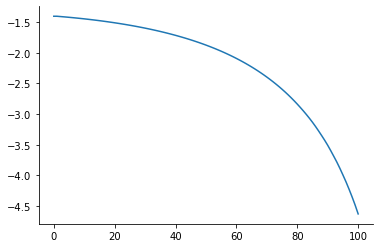

In [9]:
plt.plot(model_res['v0_dy'])

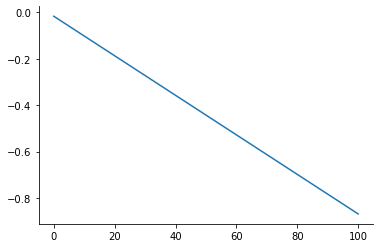

In [12]:
plt.plot((η-1)/δ*d_Λ)

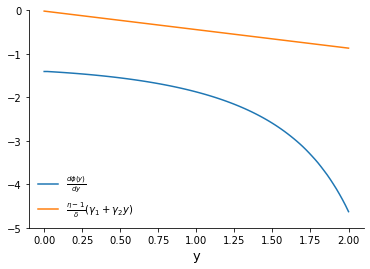

In [28]:
plt.plot(y_grid, model_res['v0_dy'], label=r'$\frac{d \phi(y)}{d y}$')
plt.plot(y_grid, (η-1)/δ*d_Λ, label=r'$\frac{\eta-1}{\delta} (\gamma_1 + \gamma_2 y)$')
plt.ylim(-5, 0)
plt.xlabel('y', fontsize=13)
plt.legend(frameon=False)
plt.savefig('plot.pdf')

In [30]:
model_res['v0_dy']

array([-1.40571305, -1.40571305, -1.40988238, -1.41414783, -1.41854476,
       -1.42308875, -1.42778799, -1.43264789, -1.43767287, -1.44286708,
       -1.44823463, -1.45377971, -1.45950664, -1.46541986, -1.47152399,
       -1.47782378, -1.48432417, -1.49103027, -1.49794736, -1.50508092,
       -1.51243663, -1.52002038, -1.52783827, -1.53589663, -1.54420203,
       -1.5527613 , -1.5615815 , -1.57066999, -1.5800344 , -1.58968268,
       -1.59962306, -1.60986415, -1.62041485, -1.63128447, -1.64248266,
       -1.65401952, -1.66590552, -1.67815162, -1.69076922, -1.70377023,
       -1.71716706, -1.73097268, -1.74520065, -1.75986513, -1.77498091,
       -1.79056348, -1.80662906, -1.82319462, -1.84027791, -1.85789758,
       -1.87607315, -1.8948251 , -1.91417496, -1.93414536, -1.95476009,
       -1.97604422, -1.99802414, -2.02072763, -2.04418391, -2.06842372,
       -2.09347942, -2.11938519, -2.14617721, -2.17389381, -2.20257572,
       -2.23226614, -2.26301093, -2.29485861, -2.32786044, -2.36

In [31]:
(η-1)/δ*d_Λ

array([-0.0171094, -0.0256278, -0.0341462, -0.0426646, -0.051183 ,
       -0.0597014, -0.0682198, -0.0767382, -0.0852566, -0.093775 ,
       -0.1022934, -0.1108118, -0.1193302, -0.1278486, -0.136367 ,
       -0.1448854, -0.1534038, -0.1619222, -0.1704406, -0.178959 ,
       -0.1874774, -0.1959958, -0.2045142, -0.2130326, -0.221551 ,
       -0.2300694, -0.2385878, -0.2471062, -0.2556246, -0.264143 ,
       -0.2726614, -0.2811798, -0.2896982, -0.2982166, -0.306735 ,
       -0.3152534, -0.3237718, -0.3322902, -0.3408086, -0.349327 ,
       -0.3578454, -0.3663638, -0.3748822, -0.3834006, -0.391919 ,
       -0.4004374, -0.4089558, -0.4174742, -0.4259926, -0.434511 ,
       -0.4430294, -0.4515478, -0.4600662, -0.4685846, -0.477103 ,
       -0.4856214, -0.4941398, -0.5026582, -0.5111766, -0.519695 ,
       -0.5282134, -0.5367318, -0.5452502, -0.5537686, -0.562287 ,
       -0.5708054, -0.5793238, -0.5878422, -0.5963606, -0.604879 ,
       -0.6133974, -0.6219158, -0.6304342, -0.6389526, -0.6474